<h4>School of Analytics Hackthon</h4>

<b>Team</b>

<ul>
    <li>Mikhail Mironov (Михаил Миронов)</li>
    <li>Bogdan Ivanov (Богдан Иванов)</li>
</ul>

In [1]:
from typing import *
from tqdm import tqdm


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

<h4>Load data and perform EDA</h4>

In [2]:
df_retention: pd.DataFrame = pd.read_csv("subscription_retention_and_prices.csv") # retention curves for the next 2 years
df_actions: pd.DataFrame = pd.read_csv("user_event_data.csv") # user actions during the experiment

df_actions.head(3)

,user_id,group,event,revenue
0,user_A_45620105,A,user_started_onboarding,0
1,user_A_45620105,A,user_reached_payment_screen,0
2,user_A_45620105,A,user_subscribed_quarterly,500


In [3]:
# plot retention curves
df_cashflows: pd.DataFrame = df_retention.copy()
# expected cashflow from one monthly user
df_cashflows["monthly_expected_revenue"] = df_cashflows["Monthly Retention"] * df_cashflows["Monthly Price"]

# find expected cashflows for quarterly and annual users
df_cashflows["is_start_quarter"] = df_cashflows.index % 3 == 0 # create bool indicating start of each quarter
df_cashflows["quarterly_expected_revenue"] = (
    df_cashflows["is_start_quarter"] * df_cashflows["Quarterly Price"] * df_cashflows["Quarterly Retention"]
)

df_cashflows["is_start_year"] = df_cashflows.index % 12 == 0
df_cashflows["annual_expected_revenue"] = (
    df_cashflows["is_start_year"] * df_cashflows["Annual Price"] * df_cashflows["Annual Retention"]
)

df_cashflows = df_cashflows.drop(columns=["is_start_quarter", "is_start_year"])
df_cashflows.head()

,Month,Monthly Retention,Quarterly Retention,Annual Retention,Monthly Price,Quarterly Price,Annual Price,monthly_expected_revenue,quarterly_expected_revenue,annual_expected_revenue
0,1,1.0000,1.0,1.0,300,500,1200,300.00,500.0,1200.0
1,2,0.9000,1.0,1.0,300,500,1200,270.00,0.0,0.0
2,3,0.8100,1.0,1.0,300,500,1200,243.00,0.0,0.0
3,4,0.7290,0.7,1.0,300,500,1200,218.70,350.0,0.0
4,5,0.6561,0.7,1.0,300,500,1200,196.83,0.0,0.0


<h4>Find cumsum of the expected cashflows computed above</h4>

In [4]:
cols_cashflows: List[str] = ["monthly_expected_revenue", "quarterly_expected_revenue", "annual_expected_revenue"]

# Compute cumsum of the expected cashflows
for col in cols_cashflows:
    df_cashflows[f"{col}_cumsum"] = df_cashflows[col].cumsum()

df_cashflows.head(2)

,Month,Monthly Retention,Quarterly Retention,Annual Retention,Monthly Price,Quarterly Price,Annual Price,monthly_expected_revenue,quarterly_expected_revenue,annual_expected_revenue,monthly_expected_revenue_cumsum,quarterly_expected_revenue_cumsum,annual_expected_revenue_cumsum
0,1,1.0,1.0,1.0,300,500,1200,300.0,500.0,1200.0,300.0,500.0,1200.0
1,2,0.9,1.0,1.0,300,500,1200,270.0,0.0,0.0,570.0,500.0,1200.0


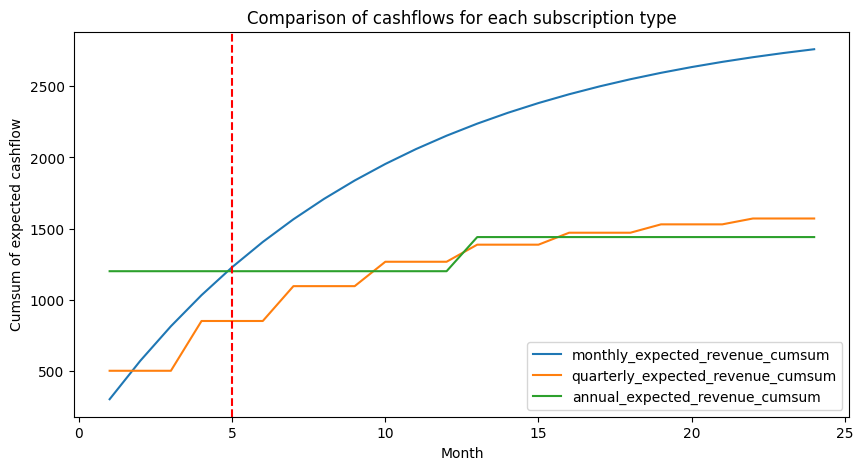

In [5]:
df_cashflows.plot(
    x="Month", y=[f"{col}_cumsum" for col in cols_cashflows], figsize=(10, 5)
)

plt.title("Comparison of cashflows for each subscription type")
plt.ylabel("Cumsum of expected cashflow")

plt.axvline(x=5, color="red", linestyle="--")

plt.show()

<p>We can see that for these given retention curves monthly subscription plan is better in terms of expected revenue at almost any month starting from 5. Therefore if there is no requirement to match any revenue threshold within the first 5 months, then we should implement measures that increase conversions to monthly subscription plans.</p>

<h4>Unique events</h4>

In [6]:
# unique user events are the same as described in the case description
df_actions["event"].unique()

array(['user_started_onboarding', 'user_reached_payment_screen',
       'user_subscribed_quarterly', 'user_subscribed_monthly',
       'user_started_trial', 'trial_converted_to_annual'], dtype=object)

<h4>Study events</h4>

<p>2000 users participated in the experiment with random assignment to groups (hopefully) if the design of the experiment was correct</p>

In [7]:
df_actions.groupby("group")["user_id"].nunique() 

group
A    1000
B    1000
Name: user_id, dtype: int64

In [8]:
# we want to explode event column to dummy columns
df_users = (
    df_actions
    .sort_values(by="user_id", ascending=True)
    .reset_index(drop=True)
)

# Get dummies for each event
df_users = pd.concat([df_users, pd.get_dummies(df_users["event"])], axis=1)
df_users.head(3)

,user_id,group,event,revenue,trial_converted_to_annual,user_reached_payment_screen,user_started_onboarding,user_started_trial,user_subscribed_monthly,user_subscribed_quarterly
0,user_A_10273956,A,user_started_onboarding,0,False,False,True,False,False,False
1,user_A_10273956,A,user_reached_payment_screen,0,False,True,False,False,False,False
2,user_A_10416578,A,user_started_onboarding,0,False,False,True,False,False,False


In [9]:
df_users.shape

(4735, 10)

<p>Just to make sure that this transformation doesn't lose any important infromation we will check if there is one subscribing action per user_id so that we dont miss renewals or terminations of subscriptions</p>

In [10]:
product_events: List[str] = df_users["event"].unique().tolist()

df_users.groupby("user_id")[product_events].sum().max() # -> each product event occurs once for all user_ids -> good :)

user_started_onboarding        1
user_reached_payment_screen    1
user_started_trial             1
trial_converted_to_annual      1
user_subscribed_monthly        1
user_subscribed_quarterly      1
dtype: int64

In [11]:
# convert to wide format and append previous features

df_users: pd.DataFrame = pd.merge(
    left=df_users.groupby("user_id")[product_events].any(), 
    right=df_users.groupby("user_id").agg(
        group=("group", "first"),
        revenue=("revenue", "sum") # compute revenue from each user 
    ),
    how="left",
    left_index=True, right_index=True
)

df_users.head(5)

,user_started_onboarding,user_reached_payment_screen,user_started_trial,trial_converted_to_annual,user_subscribed_monthly,user_subscribed_quarterly,group,revenue
user_id,,,,,,,,
user_A_10273956,True,True,False,False,False,False,A,0
user_A_10416578,True,False,False,False,False,False,A,0
user_A_10491016,True,True,False,False,False,False,A,0
user_A_10522808,True,True,False,False,False,False,A,0
user_A_10557939,True,False,False,False,False,False,A,0


In [12]:
df_users.shape

(2000, 8)

<h4>It seems like it is impossible to start the trail without reaching the paywall</h4>

In [13]:
df_users[
    ~df_users["user_reached_payment_screen"] & df_users["user_started_trial"]
]

,user_started_onboarding,user_reached_payment_screen,user_started_trial,trial_converted_to_annual,user_subscribed_monthly,user_subscribed_quarterly,group,revenue
user_id,,,,,,,,


<h4>Study conversion rates from payment screen to any plan. Conversion funnel</h4>

<p>A is a control group, B is a treatment group (new UI or whatever)</p>

In [14]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [15]:
# group by and compute all conversions from different stages: from both starting page and paywall


def compute_comversions(df_users: pd.DataFrame) -> pd.DataFrame:
    """Computes conversions and returns a comparison of funnels between treatment and control groups"""
    conversions: List[Dict[str, float]] = []

    for group, df_group in df_users.groupby("group"):
        group_size: int = df_group.shape[0]

        conversions.append({
            "group": group,
            "conversion_to_paywall": df_group["user_reached_payment_screen"].sum() / group_size,
            "conversion_to_trial": df_group["user_started_trial"].sum() / group_size,
            "conversion_paywall_to_trial": df_group["user_started_trial"].sum() / df_group["user_reached_payment_screen"].sum(),
            "conversion_trial_to_annual": df_group["trial_converted_to_annual"].sum() / group_size,
            # Monthly
            "conversion_to_monthly": df_group["user_subscribed_monthly"].sum() / group_size,
            "conversion_paywall_to_monthly": df_group["user_subscribed_monthly"].sum() / df_group["user_reached_payment_screen"].sum(),
            # Quarterly conversion
            "conversion_to_quarterly": df_group["user_subscribed_quarterly"].sum() / group_size,
            "conversion_paywall_to_quarterly": df_group["user_subscribed_quarterly"].sum() / df_group["user_reached_payment_screen"].sum(),
        })

    df_funnel: pd.DataFrame = pd.DataFrame(conversions)
    return df_funnel

In [16]:
# color with green which group A, B has higher conversion rate
df_funnel: pd.DataFrame = compute_comversions(df_users=df_users)

df_funnel = df_funnel.style.apply(
    highlight_max, subset=pd.IndexSlice[:, df_funnel.columns[1:]], axis=0
)
df_funnel

,group,conversion_to_paywall,conversion_to_trial,conversion_paywall_to_trial,conversion_trial_to_annual,conversion_to_monthly,conversion_paywall_to_monthly,conversion_to_quarterly,conversion_paywall_to_quarterly
0,A,0.831000,0.117000,0.140794,0.087000,0.241000,0.290012,0.072000,0.086643
1,B,0.859000,0.072000,0.083818,0.059000,0.163000,0.189756,0.234000,0.272410


In [17]:
# compare revenues generated in each group
df_actions.groupby(["group", "event"], observed=False).agg(
    num_users=("user_id", "count"),
    total_revenue=("revenue", "sum")
)

num_users  total_revenue
group event                                                
A     trial_converted_to_annual           87         104400
      user_reached_payment_screen        831              0
      user_started_onboarding           1000              0
      user_started_trial                 117              0
      user_subscribed_monthly            241          72300
      user_subscribed_quarterly           72          36000
B     trial_converted_to_annual           59          70800
      user_reached_payment_screen        859              0
      user_started_onboarding           1000              0
      user_started_trial                  72              0
      user_subscribed_monthly            163          48900
      user_subscribed_quarterly          234         117000

<p>We see that in group B the number of quarterly subscriptions has increased dramatically compared to group A, this resulted in significant growth of revenue generated by quarterly subscriptions while other revenue streams have decreased</p>

In [18]:
# create a column indicating a subscription plan chosen by user_id

subscription_cols = [
    "trial_converted_to_annual", "user_subscribed_monthly", "user_subscribed_quarterly"
]

df_users["subscription_type"] = (df_users[subscription_cols] * subscription_cols).agg("".join, axis=1).str.strip()

df_users["subscription_type"] = (
    df_users["subscription_type"]
    .replace("", None).str.split("_")
    .apply(lambda x: x[-1] if isinstance(x, list) else x)
)

df_users.tail()

,user_started_onboarding,user_reached_payment_screen,user_started_trial,trial_converted_to_annual,user_subscribed_monthly,user_subscribed_quarterly,group,revenue,subscription_type
user_id,,,,,,,,,
user_B_99706857,True,True,False,False,False,True,B,500,quarterly
user_B_9983257,True,True,False,False,False,True,B,500,quarterly
user_B_99872923,True,True,False,False,False,False,B,0,None
user_B_99924662,True,True,False,False,True,False,B,300,monthly
user_B_9994575,True,True,True,True,False,False,B,1200,annual


In [19]:
# add expected cashflows for the next 2 years for all users depending on their subscription type
for i in range(1, 25):
    df_users[f"expected_cashflow_month_{i}"] = 0


for i in tqdm(range(1, 25)):
    expected_cashflows: List[float] = []

    for subscription_type in df_users["subscription_type"]:
        expected_cashflows.append(
            df_cashflows[f"{subscription_type}_expected_revenue"].iloc[i-1] if subscription_type else 0
        )

    df_users[f"expected_cashflow_month_{i}"] = expected_cashflows

df_users.tail()

100%|██████████| 24/24 [00:00<00:00, 320.49it/s]


,user_started_onboarding,user_reached_payment_screen,user_started_trial,trial_converted_to_annual,user_subscribed_monthly,user_subscribed_quarterly,group,revenue,subscription_type,expected_cashflow_month_1,...,expected_cashflow_month_15,expected_cashflow_month_16,expected_cashflow_month_17,expected_cashflow_month_18,expected_cashflow_month_19,expected_cashflow_month_20,expected_cashflow_month_21,expected_cashflow_month_22,expected_cashflow_month_23,expected_cashflow_month_24
user_id,,,,,,,,,,,,,,,,,,,,,
user_B_99706857,True,True,False,False,False,True,B,500,quarterly,500.0,...,0.000000,84.03500,0.000000,0.000000,58.824500,0.000000,0.000000,41.177150,0.000000,0.000000
user_B_9983257,True,True,False,False,False,True,B,500,quarterly,500.0,...,0.000000,84.03500,0.000000,0.000000,58.824500,0.000000,0.000000,41.177150,0.000000,0.000000
user_B_99872923,True,True,False,False,False,False,B,0,None,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
user_B_99924662,True,True,False,False,True,False,B,300,monthly,300.0,...,68.630377,61.76734,55.590606,50.031545,45.028391,40.525552,36.472996,32.825697,29.543127,26.588814
user_B_9994575,True,True,True,True,False,False,B,1200,annual,1200.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
df_users.groupby("group")

<h4>Bootstrap</h4>

<p>We will resample groups to see how cashflows compares to each other</p>

In [21]:
compute_comversions(df_users=df_users)

,group,conversion_to_paywall,conversion_to_trial,conversion_paywall_to_trial,conversion_trial_to_annual,conversion_to_monthly,conversion_paywall_to_monthly,conversion_to_quarterly,conversion_paywall_to_quarterly
0,A,0.831,0.117,0.140794,0.087,0.241,0.290012,0.072,0.086643
1,B,0.859,0.072,0.083818,0.059,0.163,0.189756,0.234,0.272410


In [22]:
def resample_experiment(df: pd.DataFrame, num_resamples: int = 1000) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Resamples groups and computes differences between treatment and control groups"""

    cashflow_cols: List[str] = [f"expected_cashflow_month_{i}" for i in range(1, 25)]
    deltas: List[Dict[str, float]] = []
    conversion_deltas: List[Dict[str, float]] = []

    for _ in tqdm(range(num_resamples)):
        df_resampled: pd.DataFrame = df.sample(n=df.shape[0], replace=True).copy()

        # Compute differences in cashflows each month between group B and A
        cashflow_deltas: Dict[str, float] = (
            df_resampled.groupby("group")[cashflow_cols]
            .sum().diff().iloc[-1].to_dict() # -> group B - group A columnwise
        )
        deltas.append(cashflow_deltas)

        # Conversion deltas
        df_conversions: pd.DataFrame = compute_comversions(df_users=df_resampled)
        conversion_diffs: Dict[str, float] = df_conversions.iloc[:, 1:].diff().iloc[-1].to_dict() # key-value conversion B - A
        conversion_deltas.append(conversion_diffs)


    return pd.DataFrame(deltas), pd.DataFrame(conversion_deltas)

In [23]:
df_deltas, df_conversions = resample_experiment(df=df_users, num_resamples=100000)

100%|██████████| 100000/100000 [05:48<00:00, 286.71it/s]


<h4>Compare conversion funnels</h4>

<p>Below we plot histograms of differences between B - A for different conversions. If the distribution is mostly to the right of 0 vertical line, then treatment group is better than the control for this given conversion metric.</p>

In [24]:
df_conversions.shape

(100000, 8)

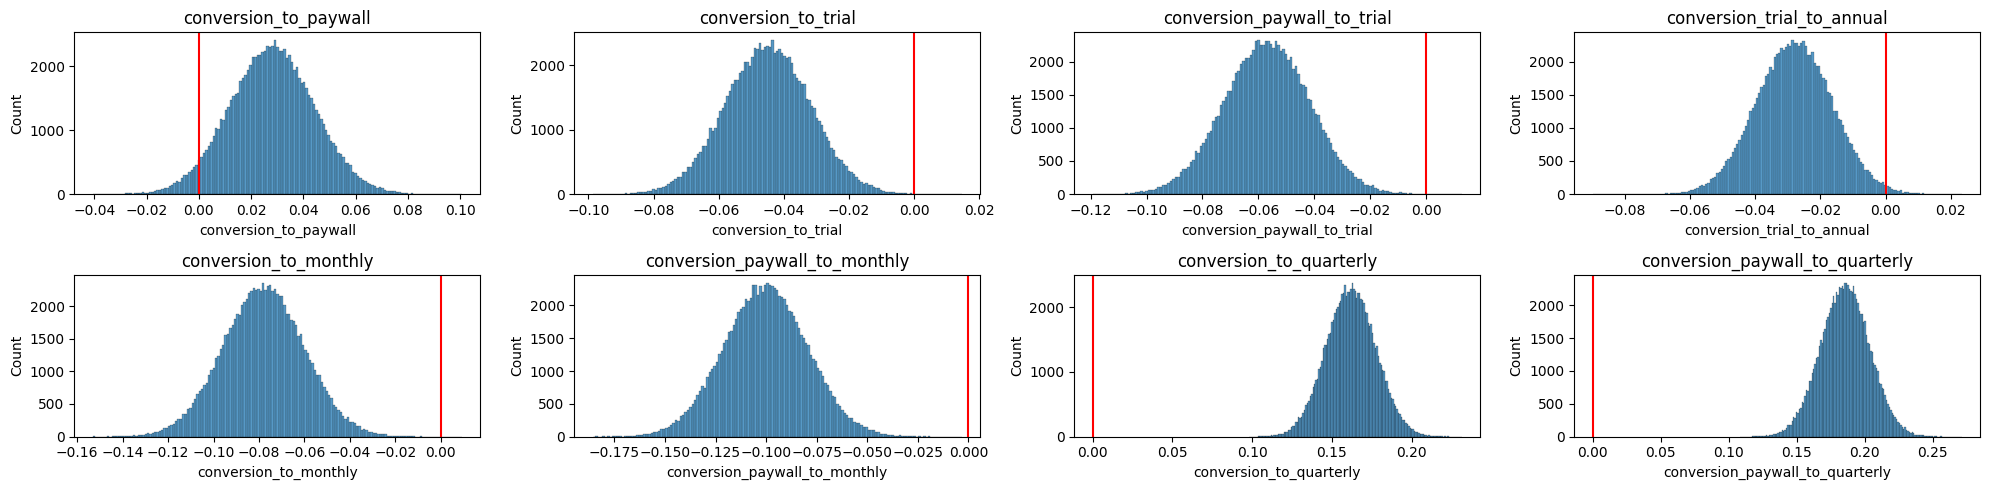

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(20, 5))
axs = axs.flatten()

for col, ax in zip(df_conversions.columns, axs):
    sns.histplot(
        data=df_conversions, x=col, ax=ax,
    )
    ax.set_title(col)
    ax.axvline(x=0, color="red")

plt.tight_layout()

<p>From the histograms above we can see that conversion_to_paywall improved, we can definately say that conversions to quartetly increased significantly for the treatment group while other conversions became lower</p>

In [26]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)


df_deltas_agg = df_deltas.agg([q025, "mean", q975]).T.reset_index(drop=True)

<h4>95% confidence interval on B revenue - A revenue for each month over time</h4>

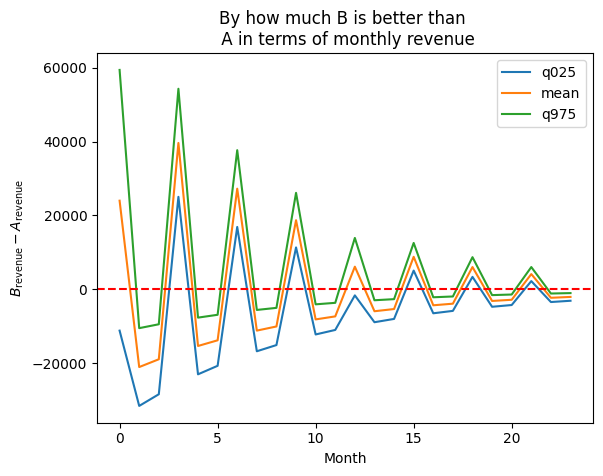

In [27]:
df_deltas_agg.plot(title="By how much B is better than \n A in terms of monthly revenue")

plt.axhline(y=0, color="red", linestyle="--")
plt.ylabel(r"$B_{\text{revenue}} - A_{\text{revenue}}$")
plt.xlabel("Month")

plt.show()

<h4>Month by month expected profit gain of B over A</h4>

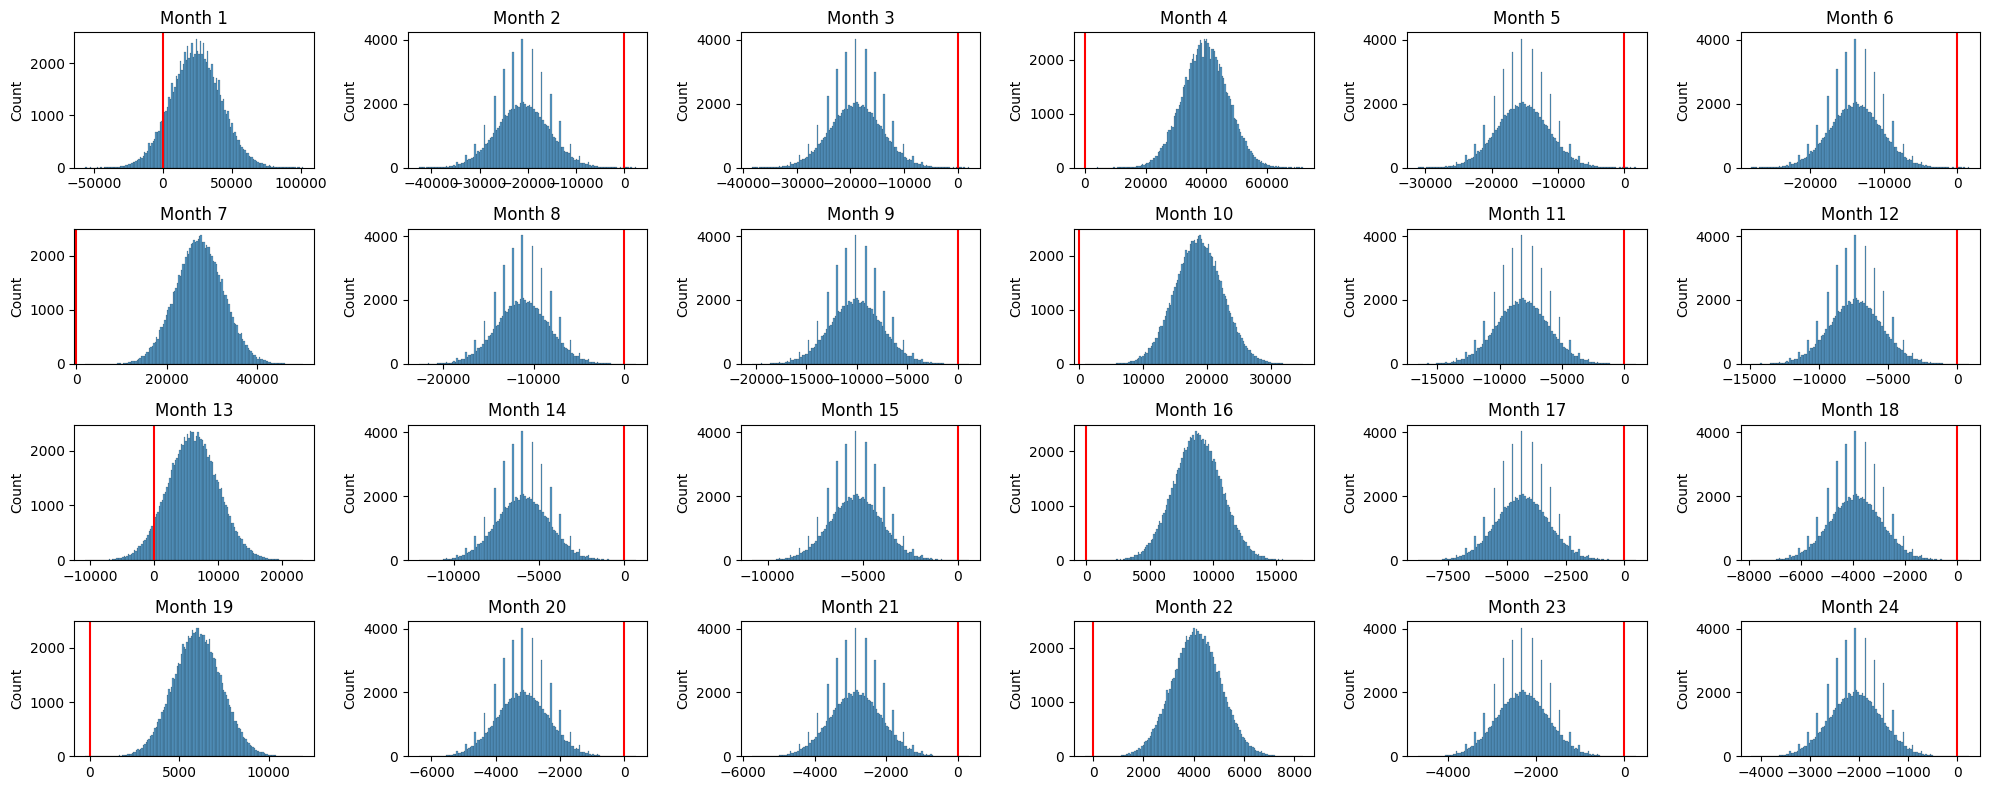

In [28]:
fig, axs = plt.subplots(4, 6, figsize=(20, 8))
axs = axs.flatten()

for i, (col, ax) in enumerate(zip(df_deltas.columns, axs)):
    sns.histplot(
        data=df_deltas, x=col, ax=ax
    )
    ax.set_xlabel(None)
    ax.set_title(f"Month {i+1}")
    ax.axvline(x=0, color="red")

plt.tight_layout()

<h4>Simulated cumulative gain over time of B over A with 95% confidence inverval</h4>

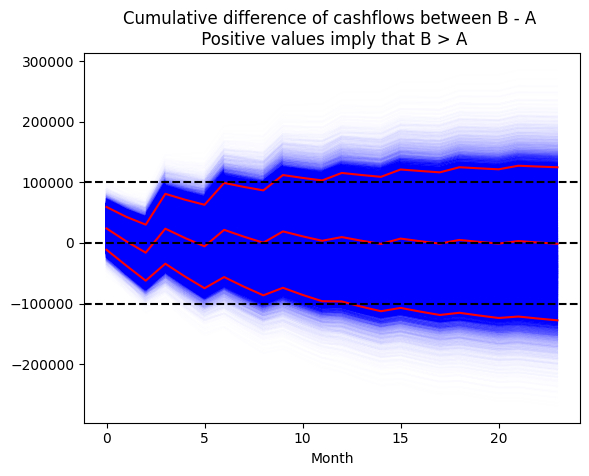

In [29]:
# how much better B than A acummulated over months 
df_cumsum_cashflow_diffs: pd.DataFrame = df_deltas.cumsum(axis=1).T.reset_index(drop=True)

# Plot simulation results
df_cumsum_cashflow_diffs.plot(alpha=.005, legend=False, color="blue")

df_cumsum_cashflow_diffs.quantile(q=.025, axis=1).plot(color="red")
df_cumsum_cashflow_diffs.quantile(q=.975, axis=1).plot(color="red")
df_cumsum_cashflow_diffs.mean(axis=1).plot(color="red")

plt.title("Cumulative difference of cashflows between B - A \n Positive values imply that B > A")
plt.xlabel("Month")

plt.axhline(y=-100000, color="black", linestyle="--")
plt.axhline(y=0, color="black", linestyle="--")
plt.axhline(y=100000, color="black", linestyle="--")


plt.show()

<h4>We can disect the plot above into histograms at each month</h4>

<p>As we can see as time goes by distributions of differences become centered at zero which implies that there is less and less gain from the treatment as time goes by</p>

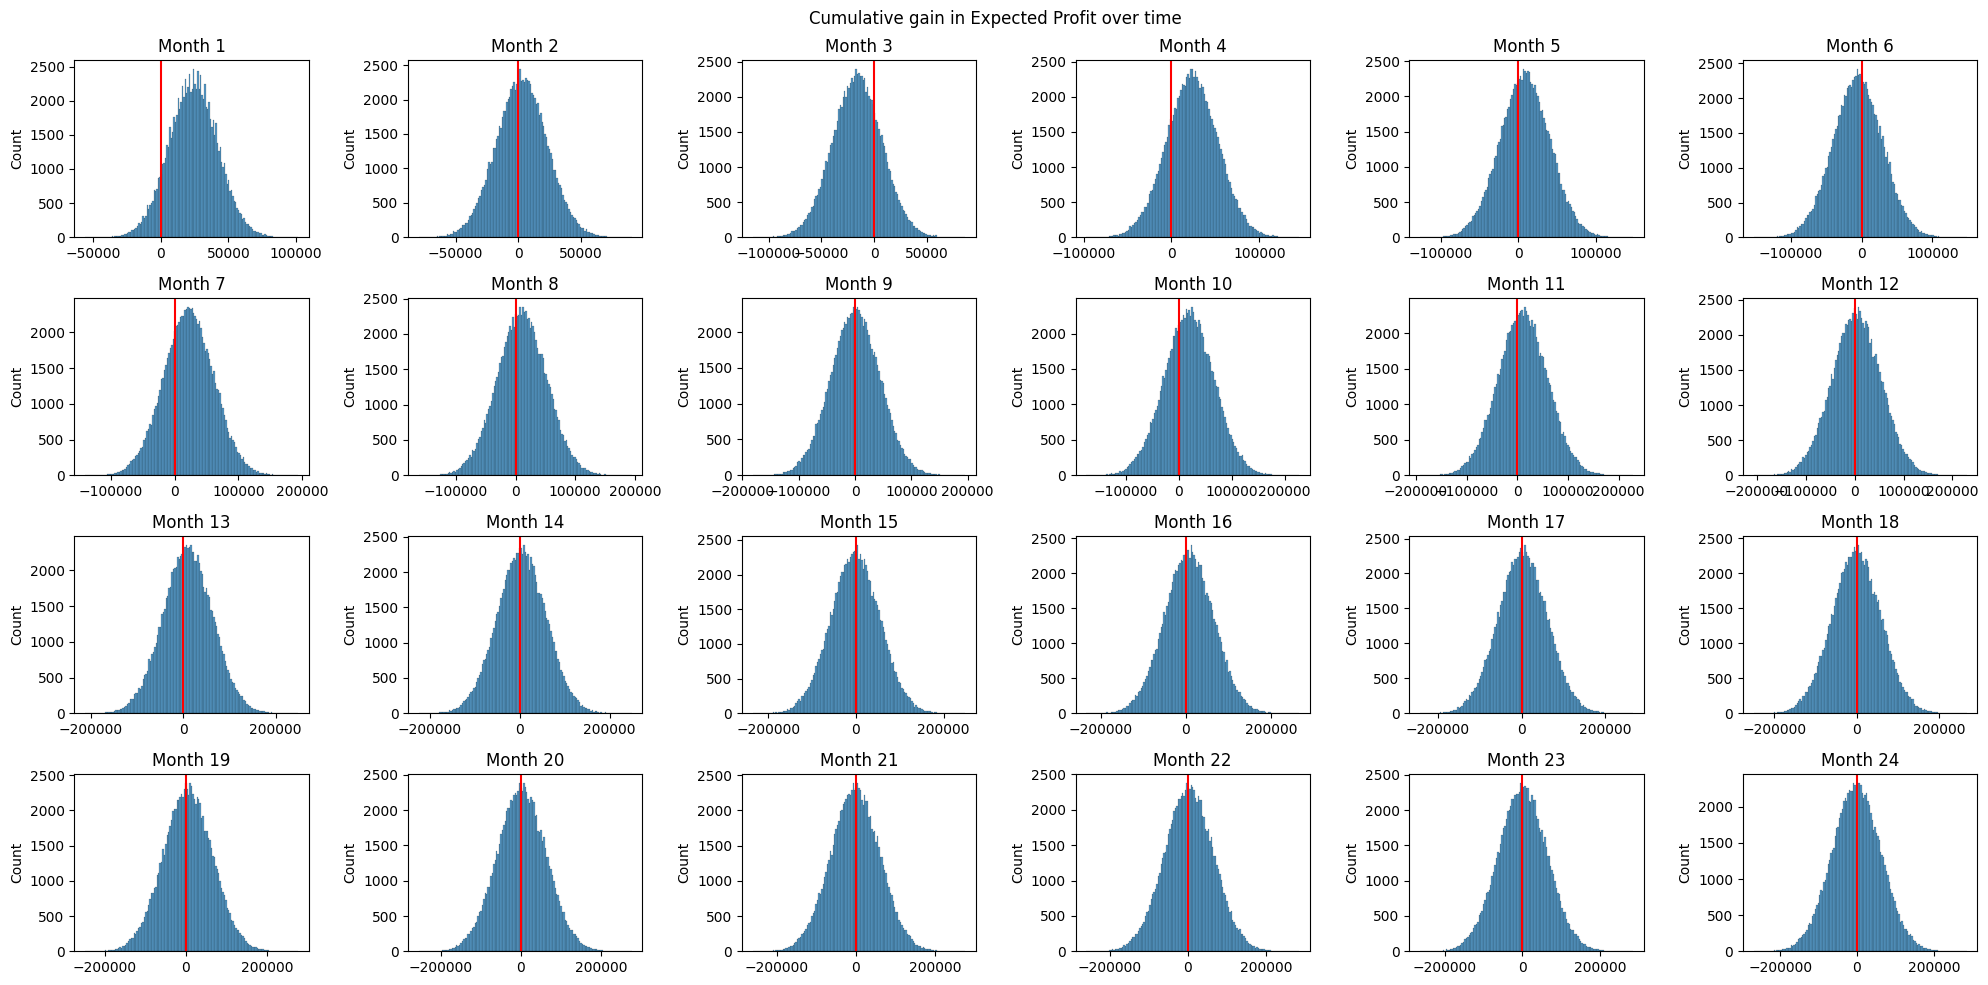

In [31]:
fig, axs = plt.subplots(4, 6, figsize=(20, 10))
axs = axs.flatten()

for i, ax in zip(range(1, 25), axs):
    sns.histplot(
        data=df_deltas.iloc[:, :i].sum(axis=1), ax=ax
    )
    ax.set_title(f"Month {i}")
    ax.axvline(x=0, color="red")

plt.suptitle("Cumulative gain in Expected Profit over time")

plt.tight_layout()

<h4>Taking into account discounting</h4>

In [32]:
annual_rate: float = 0.25 # required return
monthly_rate: float = (1 + annual_rate)**(1/12) - 1 # monthly compound rate that compounds to annual_rate

discount_factors: np.ndarray[float] = np.array([
    (1 + monthly_rate)**i for i in range(24)
])

df_discounted_cumsum_cashflow_diffs = df_cumsum_cashflow_diffs.div(discount_factors, axis=0)

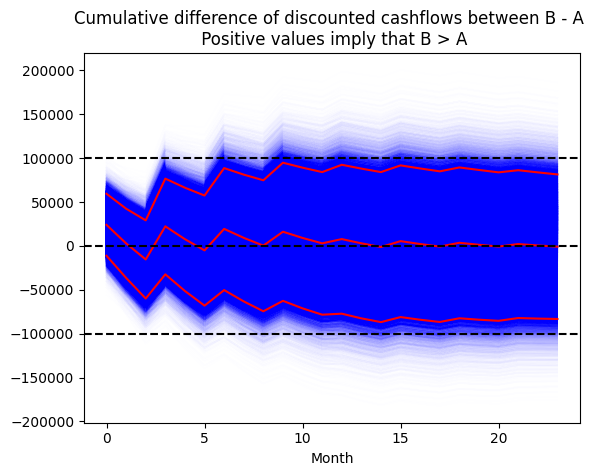

In [33]:
# how much better B than A acummulated over months 
df_discounted_cumsum_cashflow_diffs.plot(alpha=.005, legend=False, color="blue")

df_discounted_cumsum_cashflow_diffs.quantile(q=.025, axis=1).plot(color="red")
df_discounted_cumsum_cashflow_diffs.quantile(q=.975, axis=1).plot(color="red")
df_discounted_cumsum_cashflow_diffs.mean(axis=1).plot(color="red")

plt.title("Cumulative difference of discounted cashflows between B - A \n Positive values imply that B > A")
plt.xlabel("Month")

plt.axhline(y=-100000, color="black", linestyle="--")
plt.axhline(y=0, color="black", linestyle="--")
plt.axhline(y=100000, color="black", linestyle="--")

plt.show()

<p>We can see that the gain from treatment disappears over time. Initially almost all paths lie above 0 line, indicating that treatment allows us to increase revenues at the start, but this effect dies off as months go by</p>

<p>As we can see from plots above, this strategy (implementation of treatment) is actually not so much about getting higher expected profits since in the long run the distribution of expected profit gain is symmetric and centered at 0. If we as a company implement the treatment we will be able to improve incoming cashflows in the short-term which will allow us to reinvest these increased short-term profits into new projects. On the other hand if we need to make monthly payments servicing debt paying interest, then we need better cashflow month by month which is provided by strategy A.</p>